### Regression task: Real network vs Quat network vs PHM network

Toy problems:
https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379

In [1]:
import torch
import torch.nn as nn
import numpy as np

import math
import time

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torch.nn import init


import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

In [2]:
torch.__version__

'1.8.1+cu102'

In [3]:
from hypercomplex_layers import QuaternionLinear

ModuleNotFoundError: No module named 'quaternion_layers'

In [ ]:
###############
## PHM LAYER ##
###############

class PHMLayer(nn.Module):
    '''
    Parameterized Hypercomplex Multiplication (PHM) Layer.
    From the paper: 'Beyond Fully-Connected Layers with Quaternions:
        Parameterization of Hypercomplex Multiplications with 1/n Parameters'
    '''


  def __init__(self, n, in_features, out_features):
    super(PHMLayer, self).__init__()
    self.n = n
    self.in_features = in_features
    self.out_features = out_features

    self.bias = nn.Parameter(torch.Tensor(out_features))
    self.a = nn.Parameter(torch.nn.init.xavier_uniform_(torch.zeros((n, n, n))))
    self.s = nn.Parameter(torch.nn.init.xavier_uniform_(torch.zeros((n, self.out_features//n, self.in_features//n))))
    self.weight = torch.zeros((self.out_features, self.in_features))

    fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
    bound = 1 / math.sqrt(fan_in)
    init.uniform_(self.bias, -bound, bound)


  def kronecker_product1(self, a, b):
    '''
    Faster implementation for sum of Kronecker products.
    '''
    
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    out = res.reshape(siz0 + siz1)
    return out

  def kronecker_product2(self):
    '''
    Slower implementation for sum of Kronecker products.
    '''
    
    H = torch.zeros((self.out_features, self.in_features))
    for i in range(self.n):
        H = H + torch.kron(self.a[i], self.s[i])
    return H

  def forward(self, input):
    self.weight = torch.sum(self.kronecker_product1(self.a, self.s), dim=0)
#     self.weight = self.kronecker_product2() #<- SLOWER
    input = input.type(dtype=self.weight.type())
    return F.linear(input, weight=self.weight, bias=self.bias)

  def extra_repr(self) -> str:
    return 'in_features={}, out_features={}, bias={}'.format(
      self.in_features, self.out_features, self.bias is not None)
    
  def reset_parameters(self) -> None:
    init.kaiming_uniform_(self.a, a=math.sqrt(5))
    init.kaiming_uniform_(self.s, a=math.sqrt(5))
    fan_in, _ = init._calculate_fan_in_and_fan_out(self.placeholder)
    bound = 1 / math.sqrt(fan_in)
    init.uniform_(self.bias, -bound, bound)

In [56]:
phm = PHMConvLayer(4, 200, 100, 3)

In [57]:
x_conv = torch.randn(4, 200, 20, 20)
phm(x_conv).size()

torch.Size([4, 100, 200, 3, 3])
torch.Size([100, 200, 3, 3])


torch.Size([4, 100, 20, 20])

In [45]:
a = torch.randn((4,4,4))
print(a.unsqueeze(-1).unsqueeze(-3).unsqueeze(-1).unsqueeze(-1).size())

b = torch.randn((4, 25, 50, 3, 3,))

siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-4:-2]))
siz2 = torch.Size(torch.tensor(b.shape[-2:]))
res = a.unsqueeze(-1).unsqueeze(-3).unsqueeze(-1).unsqueeze(-1) * b.unsqueeze(-4).unsqueeze(-6)
siz0 = res.shape[:1]
out = res.reshape(siz0 + siz1 + siz2)


torch.Size([4, 4, 1, 4, 1, 1, 1])
torch.Size([4, 1, 25, 1, 50, 3, 3])
torch.Size([4, 4, 25, 4, 50, 3, 3])
torch.Size([100, 200])
torch.Size([3, 3])
torch.Size([4, 4, 25, 4, 50, 3, 3])
torch.Size([4, 100, 200, 3, 3])


In [135]:
input_feature = 4
hidden_size = 200
output_feature = 4
n = 4
net_type = "phm"

In [136]:
def weights_init_uniform(m):
#     m.A.data.uniform_(-0.07, 0.07)
#     m.S.data.uniform_(-0.07, 0.07)
#     m.A.data.uniform_(-1, 1)
#     m.S.data.uniform_(-1, 1)
    
#     torch.nn.init.xavier_uniform_(m.A.data)
#     torch.nn.init.xavier_uniform_(m.S.data)    
    
    # Weight A
    stdv = 1. / math.sqrt(m.A.size(1))
    m.A.data.uniform_(-stdv, stdv)
    # Weight S
    stdv = 1. / math.sqrt(m.S.size(1))
    m.S.data.uniform_(-stdv, stdv)
#     m.H.data.uniform_(-0.07, 0.07)

class RealNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(RealNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
#         x = self.hidden(x)
#         x = self.predict(x)
        x = F.relu(self.predict(x))
        return x
    
class QuatNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(QuatNet, self).__init__()
        self.hidden = QuaternionLinear(n_feature, n_hidden)
        self.predict = QuaternionLinear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
    
class PHMNet(torch.nn.Module):
    def __init__(self, n, n_feature, n_hidden, n_output):
        super(PHMNet, self).__init__()
#         self.hidden = PHM_S(n, n_feature, n_hidden)
#         self.predict = PHM_S(n, n_hidden, n_output)
        self.hidden = PHMLayer(n, n_feature, n_hidden)
        self.predict = PHMLayer(n, n_hidden, n_output)
#         self.hidden.apply(weights_init_uniform)
#         self.predict.apply(weights_init_uniform)

    def forward(self, x):
#         x = self.hidden(x)
        x = F.relu(self.hidden(x))
        x = self.predict(x) 
        return x

In [111]:
net = PHMNet(n=n, n_feature=input_feature, n_hidden=hidden_size, n_output=output_feature)
print(net)
print(net.hidden.s.size())

PHMNet(
  (hidden): PHMLayer(in_features=4, out_features=200, bias=True)
  (predict): PHMLayer(in_features=200, out_features=4, bias=True)
)
torch.Size([4, 50, 1])


torch.Size([100, 4])
torch.Size([100, 4])


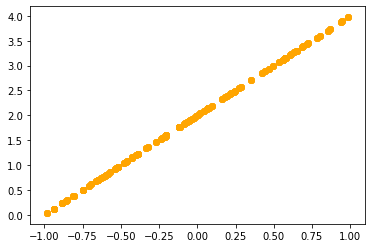

In [35]:
###### LINEAR REGRESSION

torch.manual_seed(1)

x = torch.unsqueeze(torch.linspace(-1, 1, 10000), dim=1)
y = 2*x+2
# y = x.pow(2) + 0.2*torch.rand(x.size())

# torch can only train on Variable, so convert them to Variable
x = torch.cat([x, x, x, x], dim=1)
y = torch.cat([y, y, y, y], dim=1)
x, y = Variable(x), Variable(y)

dataset = Data.TensorDataset(x, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)

for i, data in enumerate(trainloader, 0):
    x, y = data
    print(x.size())
    print(y.size())
    plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    plt.show()
    break
    print()
    print(dataset[i:10])
    print()
    print(x[i:10], y[i:10])


In [104]:
###### NONLINEAR REGRESSION

torch.manual_seed(1)

x = torch.unsqueeze(torch.linspace(-1, 1, 10000), dim=1)
y = x.pow(2) + 0.2*torch.rand(x.size())

# torch can only train on Variable, so convert them to Variable
x = torch.cat([x, x, x, x], dim=1)
y = torch.cat([y, y, y, y], dim=1)
x, y = Variable(x), Variable(y)

In [105]:
dataset = Data.TensorDataset(x, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)

torch.Size([100, 4])
torch.Size([100, 4])


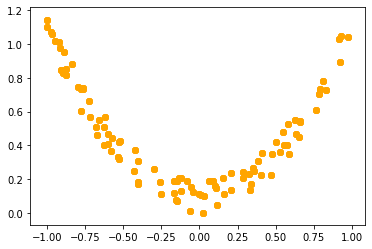

In [106]:
for i, data in enumerate(trainloader, 0):
    x, y = data
    print(x.size())
    print(y.size())
    plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    plt.show()
    break
    print()
    print(dataset[i:10])
    print()
    print(x[i:10], y[i:10])


In [107]:
for i, data in enumerate(trainloader, 0):
    print(len(data))
    x, y = data
#     print(x)
    print(y.size())
    break

2
torch.Size([100, 4])


PHMNet(
  (hidden): PHMLayer(in_features=4, out_features=200, bias=True)
  (predict): PHMLayer(in_features=200, out_features=4, bias=True)
)
Loss 0.26514098048210144
Loss 0.07276098430156708
Loss 0.08175608515739441
Loss 0.07962437719106674
Loss 0.09408658742904663
Loss 0.07706055045127869
Loss 0.0645713061094284
Loss 0.07240889966487885
Loss 0.05223216861486435
Loss 0.051964133977890015
Loss 0.040476564317941666
Loss 0.032103363424539566
Loss 0.01947120763361454
Loss 0.016113318502902985
Loss 0.007879970595240593
Loss 0.008486430160701275
Loss 0.006332795601338148
Loss 0.007977006956934929
Loss 0.0069945091381669044
Loss 0.007095855660736561


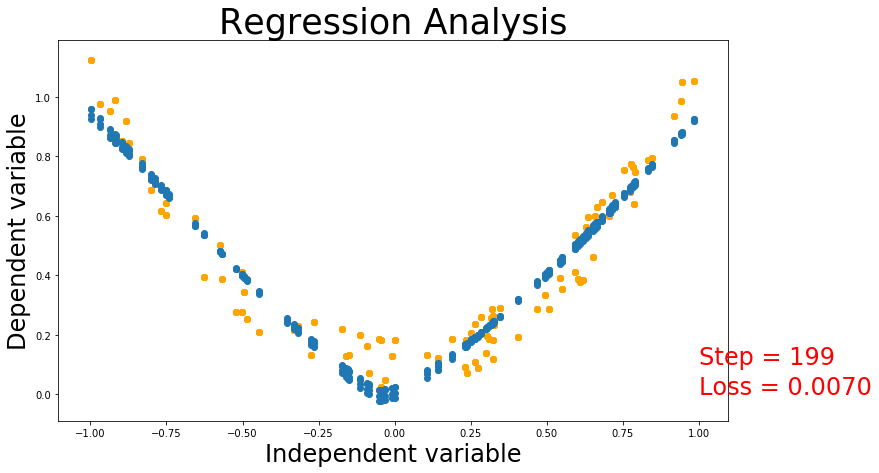

In [137]:
# # view data
# plt.figure(figsize=(10,4))
# plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
# plt.title('Regression Analysis')
# plt.xlabel('Independent varible')
# plt.ylabel('Dependent varible')
# plt.show()


if net_type == "real":
    net = RealNet(n_feature=input_feature, n_hidden=hidden_size, n_output=output_feature)
elif net_type == "quat":
    net = QuatNet(n_feature=input_feature, n_hidden=hidden_size, n_output=output_feature)
elif net_type == "phm":
    net = PHMNet(n=n, n_feature=input_feature, n_hidden=hidden_size, n_output=output_feature)
#     net = phm_net
    

print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
my_images = []
losses = []
    
if net_type == "phm":
    hidden_A_grad = []
    hidden_S_grad = []
    predict_A_grad = []
    predict_S_grad = []
elif net_type == "real":
    hidden_grad = []
    predict_grad = []
elif net_type == "quat":
    hidden_grad = []
    predict_grad = []

fig, ax = plt.subplots(figsize=(12,7))

# train the network
for t in range(200):
    for data_iter in trainloader:
        x, y = data_iter
        
    optimizer.zero_grad()  
    prediction = net(x)
#     print(prediction[0:10])
    loss = loss_func(prediction, y)
    losses.append(loss.item())
    
#     if net_type == "phm":
#         # add L1 regularization
#         regularization_loss = 0
# #         for param in net.parameters():
# #             regularization_loss += torch.sum(abs(param))

#         for i, param in enumerate(net.parameters()):
#             if i == 0 or i == 2:
#                 regularization_loss += torch.sum(abs(param))
#         loss += 0.01 * regularization_loss
    
    loss.backward()
    optimizer.step()
    
    # Print losses
    if t%10 == 0:
        print("Loss", loss.item())
#         print("[pred]")
#         print(prediction[:5])
#         print("[y]")
#         print(y[:5])
    
#     print("Loss", loss.item())
    if net_type == "phm":
#         hidden_A_grad.extend(net.hidden.A.grad.detach().numpy())
#         hidden_S_grad.extend(net.hidden.S.grad.detach().numpy())
#         predict_A_grad.extend(net.predict.A.grad.detach().numpy())
#         predict_S_grad.extend(net.predict.S.grad.detach().numpy())
        pass
    elif net_type == "real":
        hidden_grad.extend(net.hidden.weight.grad.detach().numpy())
    elif net_type == "quat":
        hidden_grad.extend(net.hidden.r_weight.grad.detach().numpy())
        hidden_grad.extend(net.hidden.i_weight.grad.detach().numpy())
        hidden_grad.extend(net.hidden.j_weight.grad.detach().numpy())
        hidden_grad.extend(net.hidden.k_weight.grad.detach().numpy())
        
    # plot and show learning process
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('Independent variable', fontsize=24)
    ax.set_ylabel('Dependent variable', fontsize=24)
#     ax.set_xlim(-1.05, 1.5)
#     ax.set_ylim(-0.25, 1.25)
    ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
#     ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
    ax.scatter(x.data.numpy(), prediction.data.numpy())
    ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
            fontdict={'size': 24, 'color':  'red'})

    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    

# save images as a gif    
imageio.mimsave('./curve_1.gif', my_images, fps=10)


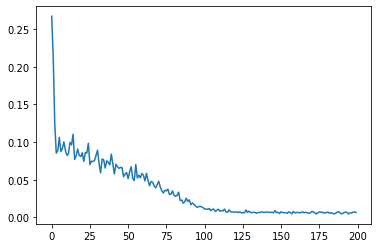

In [29]:
plt.plot(losses)

In [42]:
# RealNet:
# 0.0042
# QuatNet:
# 0.0084
# PHMNet n=1:
# 0.0119
# PHMNet n=2:
# 0.0097
# PHMNet n=4:
# 0.0067

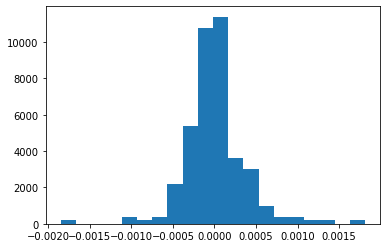

In [61]:
# hidden real
arr_real = np.array([*hidden_grad])
arr_real = arr_real.reshape(40000)
_ = plt.hist(arr_real, bins=20)

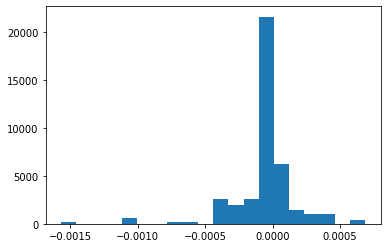

In [85]:
# hidden quat
arr_quat = np.array([*hidden_grad])
arr_quat = arr_quat.reshape(800*50)
_ = plt.hist(arr_quat, bins=20)

(800, 4, 4)
(800, 1, 50)


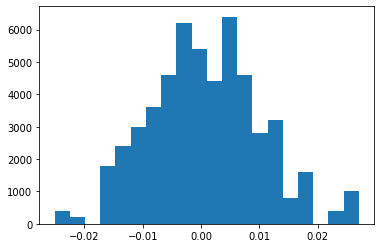

In [55]:
# hidden phm A
arrA = np.array([*hidden_A_grad])
print(arrA.shape)
arrA = arrA.reshape(1, 800*4*4)
arrS = np.array([*hidden_S_grad])
print(arrS.shape)
arrS = arrS.reshape(1, 40000)
arr = np.concatenate((arrA, arrS),axis=1)
arr = arr.reshape(52800)
_ = plt.hist(arr, bins=20)

(800, 4, 4)
(800, 50, 1)


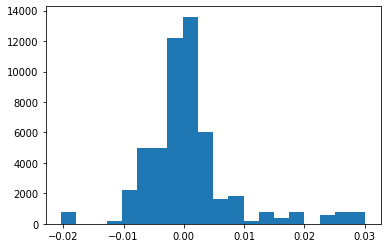

In [56]:
# predict phm A
arrA = np.array([*predict_A_grad])
print(arrA.shape)
arrA = arrA.reshape(1, 800*4*4)
arrS = np.array([*predict_S_grad])
print(arrS.shape)
arrS = arrS.reshape(1, 40000)
arr = np.concatenate((arrA, arrS),axis=1)
arr = arr.reshape(52800 )
_ = plt.hist(arr, bins=20)

In [130]:
# hidden phm A
arrA = np.array([*hidden_A_grad])
arrA = arrA.reshape(1, 400*2*2)
arrS = np.array([*hidden_S_grad])
arrS = arrS.reshape(1, 400*2*100)
arr = np.concatenate((arrA, arrS),axis=1)
arr = arr.reshape(81600)
_ = plt.hist(arr, bins=20)

ValueError: cannot reshape array of size 3200 into shape (1,1600)

In [125]:
arrA

array([[0.00661816, 0.00095711, 0.00661816, ..., 0.00284995, 0.00746035,
        0.00284995]], dtype=float32)

(800, 1, 50)


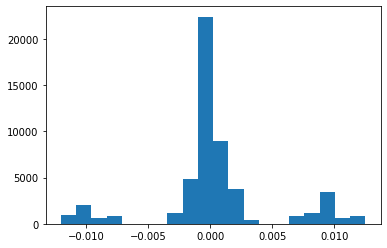

In [169]:
# NO REGULARIZATION
# hidden phm A
arrA = np.array([*hidden_A_grad])
arrA = arrA.reshape(1, 800*4*4)
arrS = np.array([*hidden_S_grad])
print(arrS.shape)

arrS = arrS.reshape(1, 800*1*50)
arr = np.concatenate((arrA, arrS),axis=1)
arr = arr.reshape(52800)
_ = plt.hist(arr, bins=20)

In [133]:
# HIDDEN SIZE 8
# Real: 0.0083
# Quat: 0.0644
# PHM n=1: 0.0093
# PHM n=2: 0.0094
# PHM n=4: 0.1466

# HIDDEN SIZE 200
# Real: 0.0040
# Quat: 0.0055
# PHM n=1: 0.0093
# PHM n=2: 0.0093
# PHM n=4: 0.0093

# HIDDEN SIZE 200 ma 800 epoche
# Real: 0.0030
# Quat: 0.0037
# PHM n=2: 0.0299
# PHM n=4: 0.0368

In [131]:
n_hidden1 = 200
n_hidden2 = 100
n = 4
BATCH_SIZE = 64
EPOCH = 200
net_type= "phm"
cuda = False

In [127]:
# def weights_init_uniform(m):
#     m.A.data.uniform_(-0.07, 0.07)
#     m.S.data.uniform_(-0.07, 0.07)
#     m.A.data.uniform_(-1, 1)
#     m.S.data.uniform_(-1, 1)
#     torch.nn.init.xavier_uniform_(m.A.data)
#     torch.nn.init.xavier_uniform_(m.S.data)

class RealNet(torch.nn.Module):
    def __init__(self, n_hidden1, n_hidden2):
        super(RealNet, self).__init__()
        self.net = torch.nn.Sequential(
        torch.nn.Linear(4, n_hidden1),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(n_hidden1, n_hidden2),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(n_hidden2, 4)
        )

    def forward(self, x):
        x = self.net(x)
        return x
    
class QuatNet(torch.nn.Module):
    def __init__(self, n_hidden1, n_hidden2):
        super(QuatNet, self).__init__()
        self.net = torch.nn.Sequential(
        QuaternionLinear(4, n_hidden1),
        torch.nn.LeakyReLU(),
        QuaternionLinear(n_hidden1, n_hidden2),
        torch.nn.LeakyReLU(),
        QuaternionLinear(n_hidden2, 4)
        )

    def forward(self, x):
        x = self.net(x)
        return x
    
class PHMNet(torch.nn.Module):
    def __init__(self, n, n_hidden1, n_hidden2):
        super(PHMNet, self).__init__()
        self.net = torch.nn.Sequential(
        PHMLayer(n, 4, n_hidden1),
        torch.nn.LeakyReLU(),
        PHMLayer(n, n_hidden1, n_hidden2),
        torch.nn.LeakyReLU(),
        PHMLayer(n, n_hidden2, 4)
        )
#         self.net[0].apply(weights_init_uniform)
#         self.net[2].apply(weights_init_uniform)
#         self.net[4].apply(weights_init_uniform)

    def forward(self, x):
        x = self.net(x)
        return x

In [129]:
torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  
y = torch.sin(x) + 0.2*torch.rand(x.size())                
x = torch.cat([x, x, x, x], dim=1)
y = torch.cat([y, y, y, y], dim=1)
x, y = Variable(x), Variable(y)

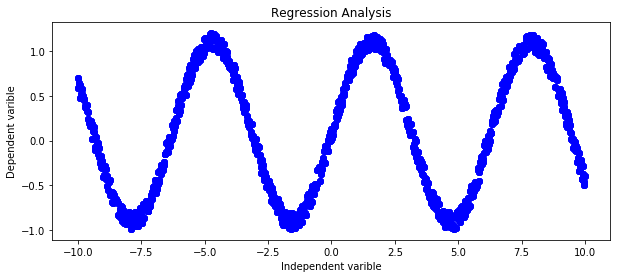

PHMNet(
  (net): Sequential(
    (0): PHMLayer(in_features=4, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): PHMLayer(in_features=200, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): PHMLayer(in_features=100, out_features=4, bias=True)
  )
)
Epoch 0
Loss 0.5652231574058533
Epoch 10
Loss 0.11183337867259979
Epoch 20
Loss 0.008075105957686901
Epoch 30
Loss 0.007088317535817623
Epoch 40
Loss 0.013223081827163696
Epoch 50
Loss 0.04562791809439659
Epoch 60
Loss 0.008198821917176247
Epoch 70
Loss 0.01125571969896555
Epoch 80
Loss 0.004737230017781258
Epoch 90
Loss 0.01381347794085741
Epoch 100
Loss 0.004070162773132324
Epoch 110
Loss 0.008292187005281448
Epoch 120
Loss 0.005293649155646563
Epoch 130
Loss 0.0037074435967952013
Epoch 140
Loss 0.008034088648855686
Epoch 150
Loss 0.006885042879730463
Epoch 160
Loss 0.007378242909908295
Epoch 170
Loss 0.00670758867636323
Epoch 180
Loss 0.005849725101143122
Epoch 190
Loss 0.0286911688745

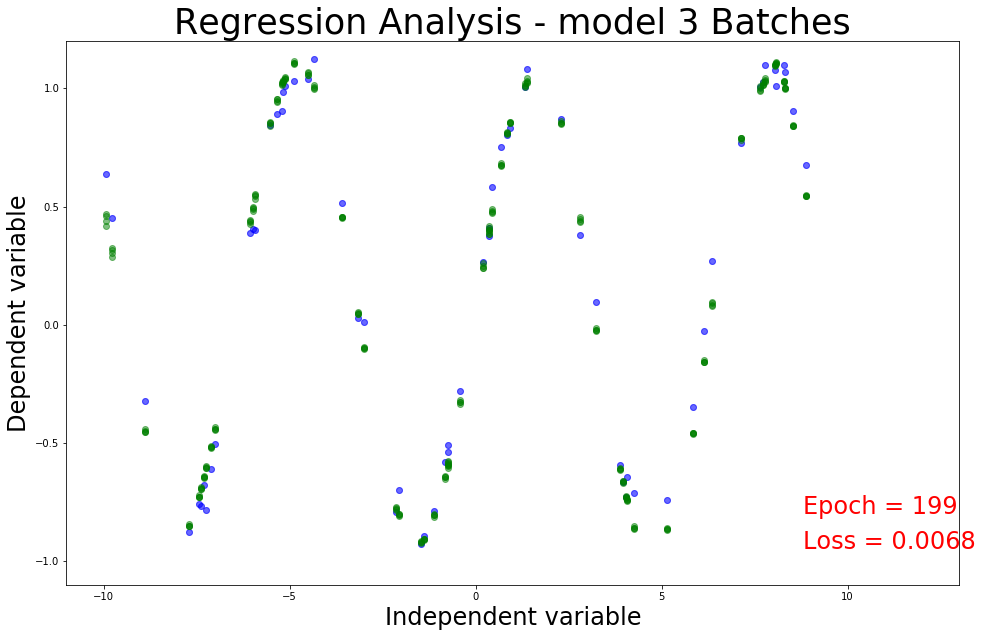

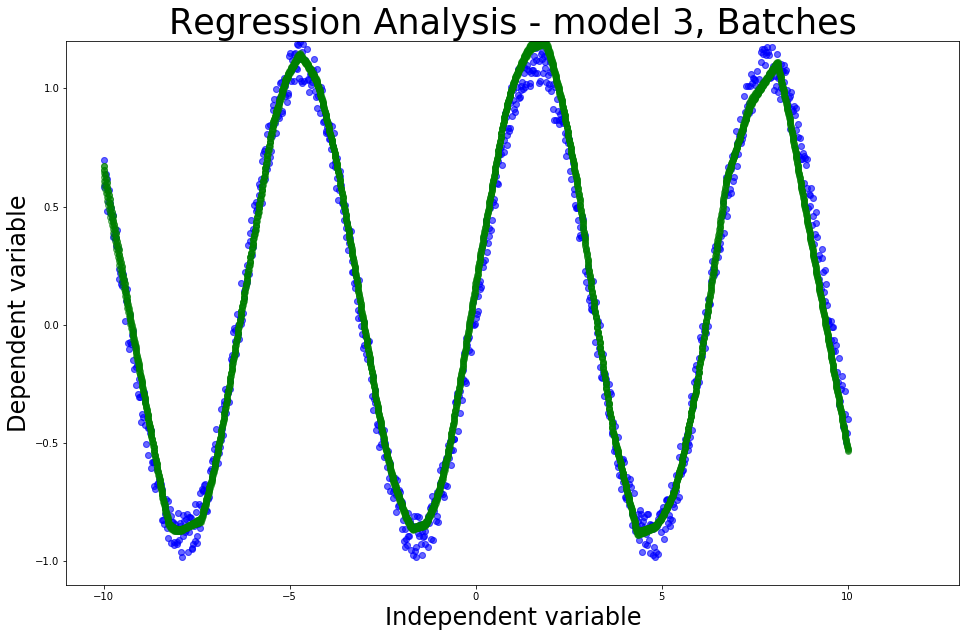

In [133]:
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.savefig('curve_2.png')
plt.show()


if net_type == "real":
    net = RealNet(n_hidden1=n_hidden1, n_hidden2=n_hidden2)
elif net_type == "quat":
    net = QuatNet(n_hidden1=n_hidden1, n_hidden2=n_hidden2)
elif net_type == "phm":
    net = PHMNet(n=n, n_hidden1=n_hidden1, n_hidden2=n_hidden2)
    

print(net)
if cuda:
    net = net.cuda()

# for i in net.parameters():
#     print(i)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1,)

my_images = []
fig, ax = plt.subplots(figsize=(16,10))

# start training
for epoch in range(EPOCH):
    batch_loss = []
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        
        if cuda:
            b_x = b_x.cuda()
            b_y = b_y.cuda()

        prediction = net(b_x)     # input x and predict based on x

        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        
        
        if step == 1:
            # plot and show learning process
            plt.cla()
            ax.set_title('Regression Analysis - model 3 Batches', fontsize=35)
            ax.set_xlabel('Independent variable', fontsize=24)
            ax.set_ylabel('Dependent variable', fontsize=24)
            ax.set_xlim(-11.0, 13.0)
            ax.set_ylim(-1.1, 1.2)
            if not cuda:
                ax.scatter(b_x.data.numpy(), b_y.data.numpy(), color = "blue", alpha=0.2)
                ax.scatter(b_x.data.numpy(), prediction.data.numpy(), color='green', alpha=0.5)
            elif cuda:
                ax.scatter(b_x.data.cpu().numpy(), b_y.data.cpu().numpy(), color = "blue", alpha=0.2)
                ax.scatter(b_x.data.cpu().numpy(), prediction.data.cpu().numpy(), color='green', alpha=0.5)

            ax.text(8.8, -0.8, 'Epoch = %d' % epoch,
                    fontdict={'size': 24, 'color':  'red'})
            ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.cpu().numpy(),
                    fontdict={'size': 24, 'color':  'red'})

            # Used to return the plot as an image array 
            # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
            fig.canvas.draw()       # draw the canvas, cache the renderer
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            my_images.append(image)

    if epoch%10==0:
        print("Epoch", epoch)
        print("Loss", loss.item())


# save images as a gif    
imageio.mimsave('./curve_2_model_3_batch.gif', my_images, fps=12)


fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_title('Regression Analysis - model 3, Batches', fontsize=35)
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
ax.set_xlim(-11.0, 13.0)
ax.set_ylim(-1.1, 1.2)
ax.scatter(x.data.cpu().numpy(), y.data.cpu().numpy(), color = "blue", alpha=0.2)
prediction = net(x.cuda())     # input x and predict based on x
ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), color='green', alpha=0.5)
plt.savefig('curve_2_model_3_batches.png')
plt.show()

In [60]:
# HIDDEN1 = 200, HIDDEN2 = 100
# Real: 0.0141 (21504)
# Quat: 0.0769
# PHM n=1: 0.0121 (21507)
# PHM n=2: 0.0052
# PHM n=4: 0.0056 (5796)

In [65]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [76]:
count_parameters(net)

21504